In [2]:
import pandas as pd
df = pd.read_csv('/Users/rajpalnati/Downloads/BREWLAB/FM_DATA.csv')

In [3]:
# Convert 'Date' to datetime and drop rows with missing Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Create the aggregated dataset for daily-level predictions (Option B)
daily_agg = df.groupby('Date').agg({
    'Foot Traffic': 'mean',  # assuming consistent value per date
    'Max Temperature (°F)': 'mean',
    'Min Temperature (°F)': 'mean',
    'Max Wind Speed (mph)': 'mean',
    'Avg Wind Speed (mph)': 'mean',
    'Precipitation (in)': 'mean',
    'Special Event': 'max',  # binary flag, if any 1 => 1
    'Total Sales': 'sum',
    'Total Transactions': 'sum'
}).reset_index()

# Create the category-level dataset for "Total Sales by Category" prediction (Option A)
category_level = df.dropna(subset=['Total Sales by Category'])


In [4]:
daily_agg

,Date,Foot Traffic,Max Temperature (°F),Min Temperature (°F),Max Wind Speed (mph),Avg Wind Speed (mph),Precipitation (in),Special Event,Total Sales,Total Transactions
0,2022-05-14,2893.0,90.0,64.0,18.0,7.7,0.00,1.0,0.00,0.0
1,2022-05-21,1745.0,77.0,57.0,24.0,11.3,0.06,0.0,0.00,0.0
2,2022-05-28,2598.0,76.0,49.0,16.0,6.1,0.26,1.0,0.00,0.0
3,2022-06-04,3438.0,87.0,58.0,16.0,5.6,0.00,0.0,0.00,0.0
4,2022-06-11,3647.0,83.0,58.0,13.0,3.0,0.11,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
72,2024-09-28,4649.0,77.0,63.0,20.0,14.8,0.25,0.0,0.00,0.0
73,2024-10-05,4267.0,87.0,57.0,15.0,9.0,0.03,1.0,4302.60,54.0
74,2024-10-12,3237.0,86.0,51.0,17.0,8.8,0.00,1.0,4252.50,48.0
75,2024-10-19,3387.0,74.0,40.0,9.0,4.5,0.00,1.0,3979.05,48.0


In [5]:
category_level

,Date,Foot Traffic,Max Temperature (°F),Min Temperature (°F),Max Wind Speed (mph),Avg Wind Speed (mph),Precipitation (in),Special Event,Category,Total Sales by Category,Total Sales,Total Transactions
81,2023-05-20,3792.0,73.0,49.0,15.0,10.8,0.0,1.0,FM-DRINKS-COFFEE,466.50,2141.15,19.0
82,2023-05-20,3792.0,73.0,49.0,15.0,10.8,0.0,1.0,FM-DRINKS-NOT-COFFEE,160.00,2141.15,19.0
83,2023-05-20,3792.0,73.0,49.0,15.0,10.8,0.0,1.0,FM-FOOD,1514.65,2141.15,19.0
84,2023-05-27,3847.0,81.0,54.0,14.0,9.5,0.0,1.0,FM-DRINKS-COFFEE,572.00,2575.00,18.0
85,2023-05-27,3847.0,81.0,54.0,14.0,9.5,0.0,1.0,FM-DRINKS-NOT-COFFEE,170.00,2575.00,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
227,2024-10-19,3387.0,74.0,40.0,9.0,4.5,0.0,1.0,FM-DRINKS-NOT-COFFEE,109.40,1326.35,16.0
228,2024-10-19,3387.0,74.0,40.0,9.0,4.5,0.0,1.0,FM-FOOD,1024.35,1326.35,16.0
229,2024-10-26,2975.0,63.0,40.0,16.0,10.4,0.0,1.0,FM-DRINKS-COFFEE,153.60,1349.35,16.0
230,2024-10-26,2975.0,63.0,40.0,16.0,10.4,0.0,1.0,FM-DRINKS-NOT-COFFEE,79.70,1349.35,16.0


RMSE: 1158.73
R² Score: -0.48


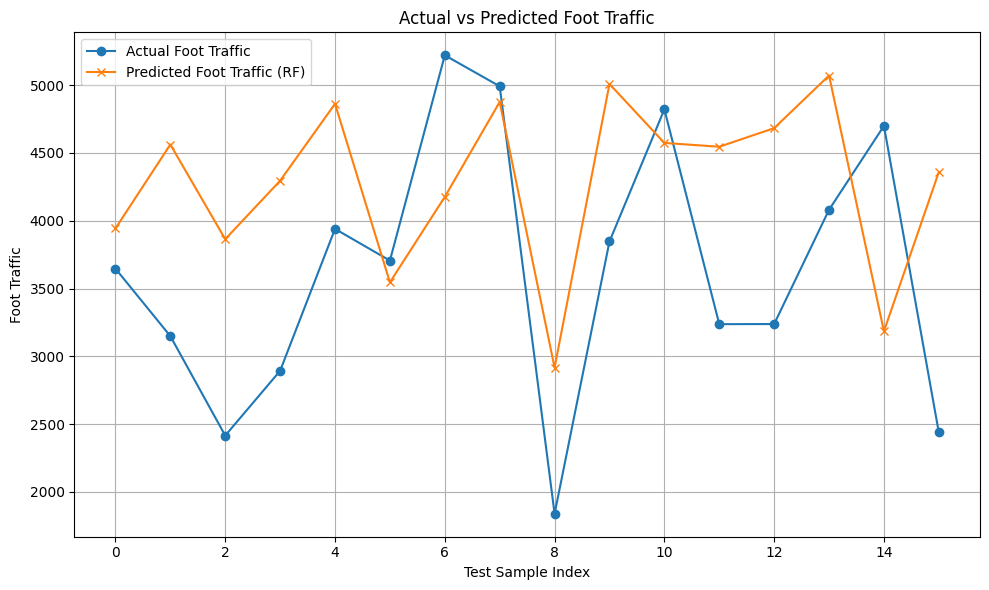

In [6]:
## FOOT TRAFFIC PREDICTION (RANDOM FOREST REGRESSOR)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Filter out rows with missing Foot Traffic or features
foot_traffic_df = daily_agg.dropna(subset=[
    'Foot Traffic', 'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)', 'Precipitation (in)', 'Special Event'
])

# Define features and target
features = ['Max Temperature (°F)', 'Min Temperature (°F)',
            'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
            'Precipitation (in)', 'Special Event']
X = foot_traffic_df[features]
y = foot_traffic_df['Foot Traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Foot Traffic', marker='o')
plt.plot(y_pred, label='Predicted Foot Traffic (RF)', marker='x')
plt.title('Actual vs Predicted Foot Traffic')
plt.xlabel('Test Sample Index')
plt.ylabel('Foot Traffic')
plt.legend()
plt.grid(True)
plt.tight_layout()


print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
plt.show()


RMSE: 1390.89
R² Score: -1.14


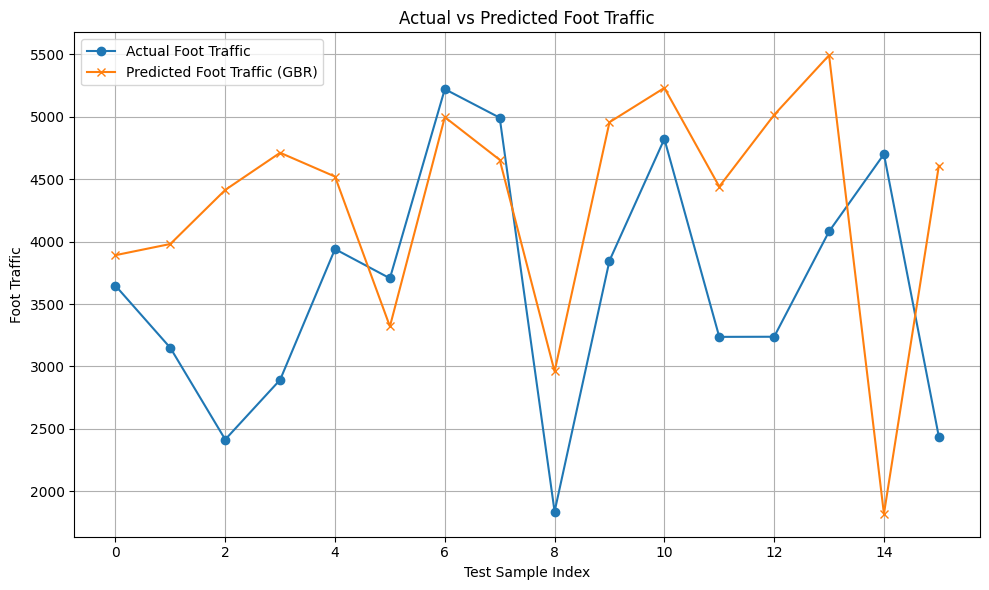

In [7]:
## FOOT TRAFFIC PREDICTION (GRADIENT BOOSTING REGRESSOR)

from sklearn.ensemble import GradientBoostingRegressor

# Try Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)

# Evaluate new model
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Foot Traffic', marker='o')
plt.plot(y_pred_gbr, label='Predicted Foot Traffic (GBR)', marker='x')
plt.title('Actual vs Predicted Foot Traffic')
plt.xlabel('Test Sample Index')
plt.ylabel('Foot Traffic')
plt.legend()
plt.grid(True)
plt.tight_layout()


print(f"RMSE: {rmse_gbr:.2f}")
print(f"R² Score: {r2_gbr:.2f}")
plt.show()


RMSE: 3382.35
R² Score: -0.24


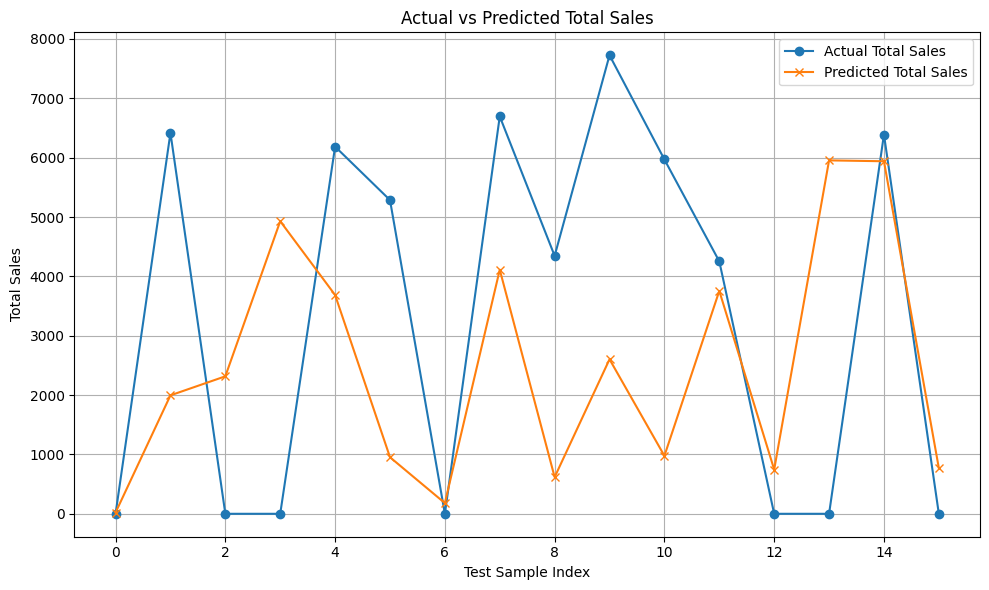

In [8]:
## TOTAL SALES PREDICTION without Foot Traffic (GRADIENT BOOST REGRESSOR)

# Drop rows with missing target or features
sales_df = daily_agg.dropna(subset=[
    'Total Sales', 'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)', 'Precipitation (in)', 'Special Event'
])

# Define features and target
features = ['Max Temperature (°F)', 'Min Temperature (°F)',
            'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
            'Precipitation (in)', 'Special Event']
X = sales_df[features]
y = sales_df['Total Sales']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Total Sales', marker='o')
plt.plot(y_pred, label='Predicted Total Sales', marker='x')
plt.title('Actual vs Predicted Total Sales')
plt.xlabel('Test Sample Index')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE: 3382.35
R² Score: -0.24


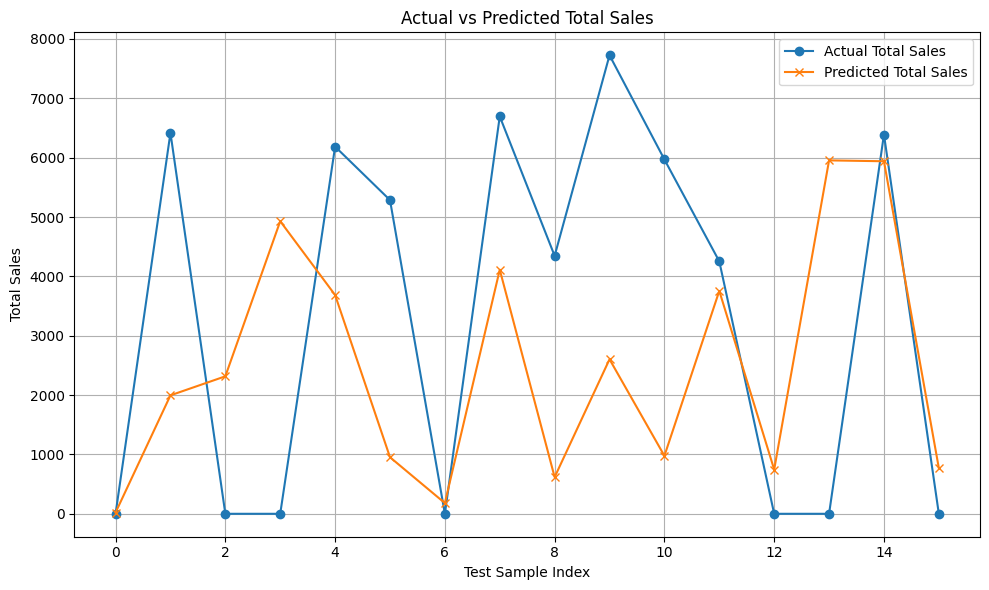

In [9]:
## TOTAL SALES PREDICTION with Foot Traffic (GRADIENT BOOST REGRESSOR)

# Drop rows with missing target or features
sales_df = daily_agg.dropna(subset=[
    'Total Sales', 'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)', 'Precipitation (in)', 'Special Event', 
    'Foot Traffic'
])

# Define features and target
features = ['Max Temperature (°F)', 'Min Temperature (°F)',
            'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
            'Precipitation (in)', 'Special Event']
X = sales_df[features]
y = sales_df['Total Sales']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Total Sales', marker='o')
plt.plot(y_pred, label='Predicted Total Sales', marker='x')
plt.title('Actual vs Predicted Total Sales')
plt.xlabel('Test Sample Index')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
######

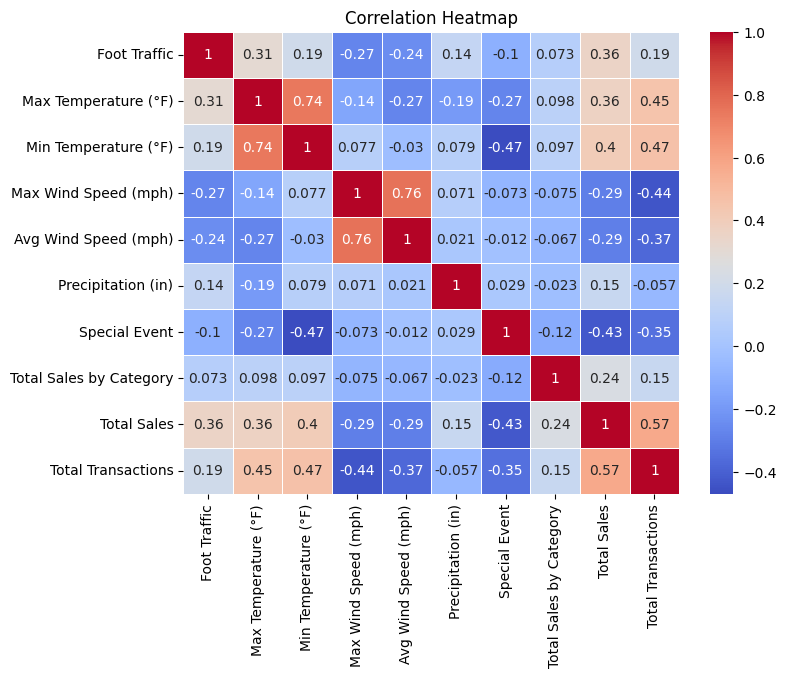

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
import pandas as pd
import statsmodels.api as sm

daily_agg['DayOfWeek'] = daily_agg['Date'].dt.dayofweek
daily_agg['Month'] = daily_agg['Date'].dt.month
daily_agg['IsWeekend'] = daily_agg['DayOfWeek'].isin([5, 6]).astype(int)

# Drop rows with missing values
sales_df = daily_agg.dropna(subset=[
    'Total Sales', 'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
    'Precipitation (in)', 'Special Event'
])

# Define features and target
features = [
    'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
    'Precipitation (in)', 'Special Event',
    'DayOfWeek', 'Month', 'IsWeekend'
]
X = sales_df[features]
y = sales_df['Total Sales']

# Add constant for intercept
X = sm.add_constant(X)

# Backward elimination
def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while True:
        model = sm.OLS(y, X[features]).fit()
        p_values = model.pvalues
        max_p = p_values.max()
        if max_p > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Removing '{excluded_feature}' (p={max_p:.4f})")
            features.remove(excluded_feature)
        else:
            break
    return model, features

# Run backward elimination
final_model, selected_features = backward_elimination(X, y)

# Summary of final model
print("\n📊 Final Model Summary:")
print(final_model.summary())


Removing 'Special Event' (p=0.4341)
Removing 'IsWeekend' (p=0.3014)
Removing 'DayOfWeek' (p=0.3014)
Removing 'Avg Wind Speed (mph)' (p=0.1727)
Removing 'Month' (p=0.3180)
Removing 'Precipitation (in)' (p=0.1929)
Removing 'Min Temperature (°F)' (p=0.3170)

📊 Final Model Summary:
                                 OLS Regression Results                                
Dep. Variable:            Total Sales   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.511
Method:                 Least Squares   F-statistic:                              41.21
Date:                Wed, 09 Apr 2025   Prob (F-statistic):                    8.42e-13
Time:                        21:24:09   Log-Likelihood:                         -723.95
No. Observations:                  77   AIC:                                      1452.
Df Residuals:                      75   BIC:                                      1457.
Df Model:        

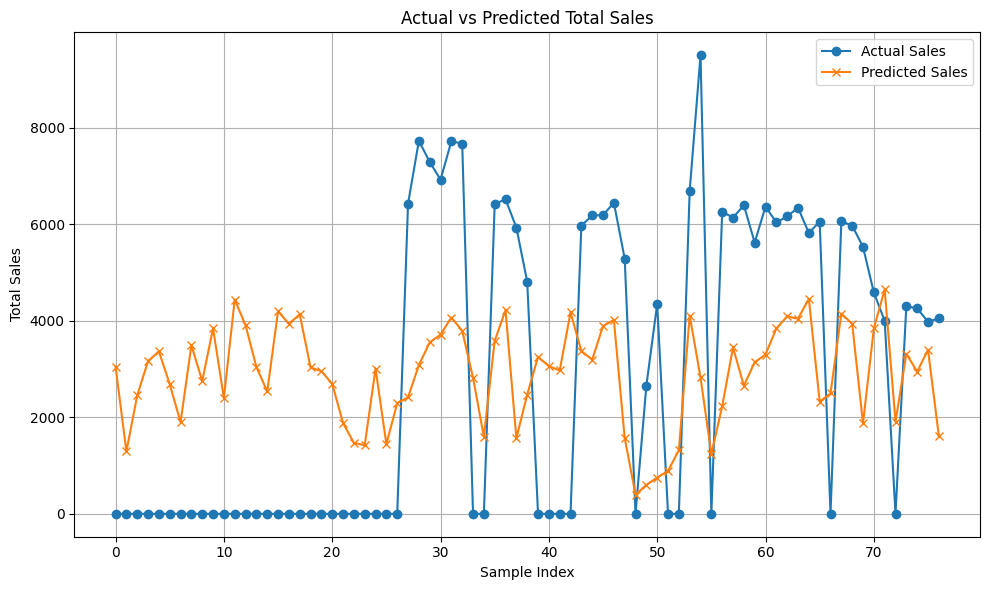

In [16]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Prepare features and target again (minimal model)
selected_features = ['Max Temperature (°F)', 'Max Wind Speed (mph)']
X = sales_df[selected_features]
y = sales_df['Total Sales']

# Add constant (optional for intercept, not needed here since final model was uncentered)
# X = sm.add_constant(X)  # Uncomment if you want to include an intercept

# Fit model
model = sm.OLS(y, X).fit()

# Predict
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Actual Sales', marker='o')
plt.plot(y_pred.values, label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Total Sales')
plt.xlabel('Sample Index')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [23]:
# Define features and target
features = [
    'Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
    'Precipitation (in)', 'Month'
]
X = sales_df[features]
y = sales_df['Total Sales']

# Add constant for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X[features]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            Total Sales   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.522
Method:                 Least Squares   F-statistic:                              15.00
Date:                Wed, 09 Apr 2025   Prob (F-statistic):                    5.33e-11
Time:                        21:49:56   Log-Likelihood:                         -720.97
No. Observations:                  77   AIC:                                      1454.
Df Residuals:                      71   BIC:                                      1468.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

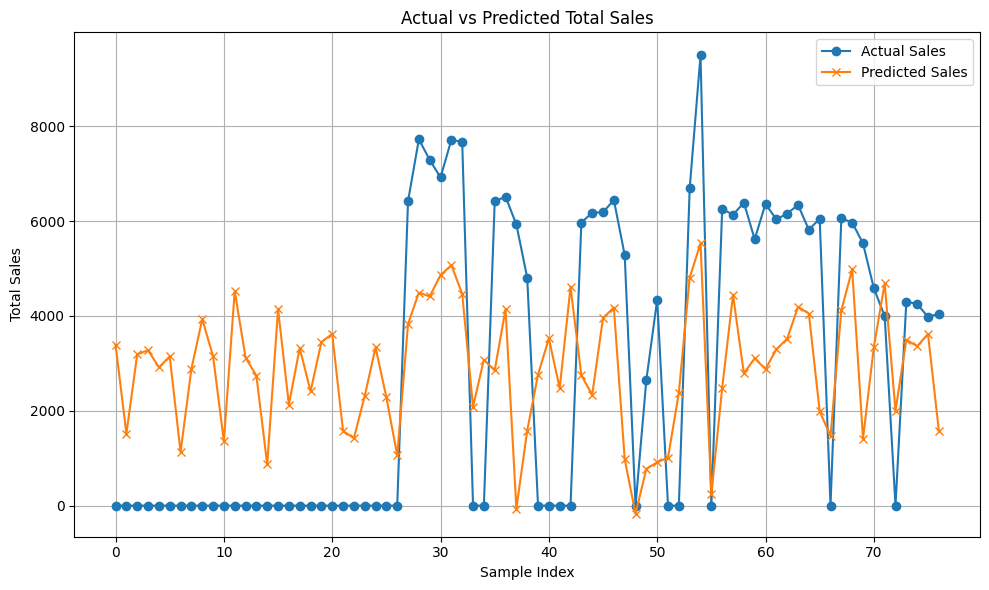

In [28]:
# Prepare features and target again (minimal model)
selected_features = ['Max Temperature (°F)', 'Min Temperature (°F)',
    'Max Wind Speed (mph)', 'Avg Wind Speed (mph)',
    'Precipitation (in)', 'Month']
X = sales_df[selected_features]
y = sales_df['Total Sales']

# Add constant (optional for intercept, not needed here since final model was uncentered)
# X = sm.add_constant(X)  # Uncomment if you want to include an intercept

# Fit model
model = sm.OLS(y, X).fit()

# Predict
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Actual Sales', marker='o')
plt.plot(y_pred.values, label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Total Sales')
plt.xlabel('Sample Index')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Use the same filtered DataFrame you used for X and y
dates = sales_df['Date']  # same number of rows as X and y

# Now do the split — dates will align
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, random_state=42
)


import matplotlib.pyplot as plt

# Assuming you have this in your test set (before train_test_split):
# X = df[features]
# y = df['Total Sales']
# date_series = df['Date']

# After splitting:
# X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, date_series, ...)

# Then when plotting:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Actual Sales', marker='o')
plt.plot(dates_test, y_pred, label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



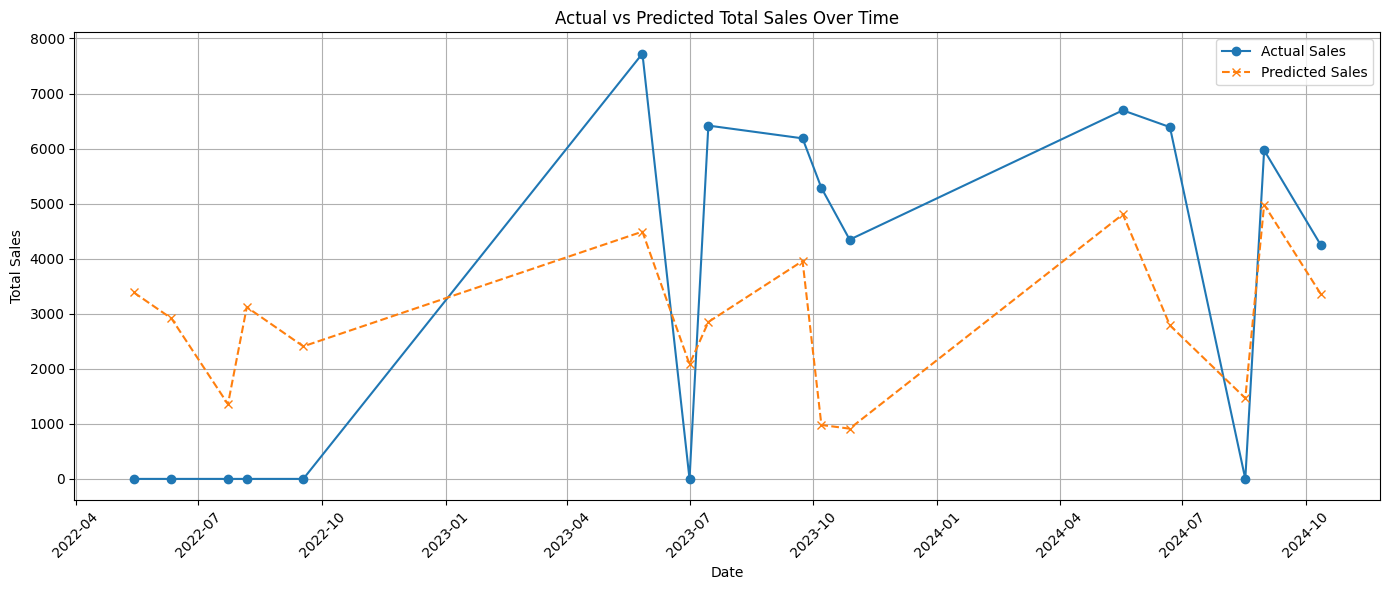

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure dates and predictions are aligned and sorted
dates_test_sorted = dates_test.sort_values()
sorted_index = dates_test_sorted.index

y_test_sorted = y_test.loc[sorted_index]
y_pred_sorted = pd.Series(y_pred, index=y_test.index).loc[sorted_index]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(dates_test_sorted, y_test_sorted.values, label='Actual Sales', marker='o', linestyle='-')
plt.plot(dates_test_sorted, y_pred_sorted.values, label='Predicted Sales', marker='x', linestyle='--')

plt.title('Actual vs Predicted Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
